MultiRAT analysis code
================
Joanes Grandjean

![rat art](../assets/img/rat_art.png)

# Foreword

This is a jupyter notebook which contains all the code for reproducing my
analysis. The code is meant to be followed step-wise. 

If re-using some of the scripts, please follow citations guidelines for
the software used. I’ve provided the links to the software wherever
possible. See also the [license](../LICENSE.md) for this software.


In [1]:
# init variables
init_folder='/home/traaffneu/joagra/code/MultiRat'
analysis_folder='/project/4180000.19/multiRat'
df_path='../assets/table/meta_data_20210622.tsv'

In [2]:
import os
import glob
import pandas as pd
import numpy as np

df = pd.read_csv(df_path, sep='\t')

In [3]:
# create empty columns for the different SBA parameters.
df['aromas_CPu_CPu'] = np.nan
df['aromas_MOp_MOp'] = np.nan
df['aromas_S1bf_S1bf'] = np.nan
df['aromas_S1bf_ACA'] = np.nan
df['aromas_S1bf_cat'] = np.nan

df['aromal_CPu_CPu'] = np.nan
df['aromal_MOp_MOp'] = np.nan
df['aromal_S1bf_S1bf'] = np.nan
df['aromal_S1bf_ACA'] = np.nan
df['aromal_S1bf_cat'] = np.nan

df['aromasr_CPu_CPu'] = np.nan
df['aromasr_MOp_MOp'] = np.nan
df['aromasr_S1bf_S1bf'] = np.nan
df['aromasr_S1bf_ACA'] = np.nan
df['aromasr_S1bf_cat'] = np.nan

df['WMCSFs_CPu_CPu'] = np.nan
df['WMCSFs_MOp_MOp'] = np.nan
df['WMCSFs_S1bf_S1bf'] = np.nan
df['WMCSFs_S1bf_ACA'] = np.nan
df['WMCSFs_S1bf_cat'] = np.nan

df['GSRs_CPu_CPu'] = np.nan
df['GSRs_MOp_MOp'] = np.nan
df['GSRs_S1bf_S1bf'] = np.nan
df['GSRs_S1bf_ACA'] = np.nan
df['GSRs_S1bf_cat'] = np.nan

In [3]:
roi_list = glob.glob((os.path.join(analysis_folder, 'template', 'roi'))+'/*')
seed_list = glob.glob((os.path.join(analysis_folder, 'scratch', 'seed','*'))+'/*')

In [5]:
import pandas as pd
pd.options.mode.chained_assignment = None

from nilearn.input_data import NiftiMasker
import re
import numpy as np

for i_orig in seed_list:
    #print(i_orig)
    i=i_orig.replace('_RAS','')
    i=i.replace('_aroma','')
    sub=int(os.path.basename(i).split('_')[0].split('-')[1])
    ses=int(os.path.basename(i).split('_')[1].split('-')[1])
    denoise=i.split('/')[6]
    seed=os.path.basename(i).split('_')[6]
    if(seed =='ACA'):
        continue
    elif(seed =='S1bf'):
        roi='ACA'
        fc_orig=df[(denoise+'_'+seed+'_'+roi)][(df['rat.sub']==sub) & (df['rat.ses']==ses)]
        fc_nan = np.isnan(fc_orig).all()
        if(fc_nan):
            r = re.compile('ACA'+'_l')
            nifti_mask=list(filter(r.findall, roi_list))[0]
            fc=NiftiMasker(nifti_mask).fit_transform(i_orig).mean()
            df[(denoise+'_'+seed+'_'+roi)][(df['rat.sub']==sub) & (df['rat.ses']==ses)]=fc
    
    roi=seed
    fc_orig=df[(denoise+'_'+seed+'_'+roi)][(df['rat.sub']==sub) & (df['rat.ses']==ses)]
    fc_nan = np.isnan(fc_orig).all()
    if(fc_nan):
        r = re.compile(seed+'_r')
        nifti_mask=list(filter(r.findall, roi_list))[0]
        fc=NiftiMasker(nifti_mask).fit_transform(i_orig).mean()
        df[(denoise+'_'+seed+'_'+roi)][(df['rat.sub']==sub) & (df['rat.ses']==ses)]=fc
    
df.to_csv(df_path, sep='\t', index=False)

In [6]:
df_exclude = df.loc[(df['exclude'] != 'yes')].loc[(df['exp.type'] == 'resting-state')]
print('missing aromas')
print(df_exclude[np.isnan(df['aromas_S1bf_S1bf']) | np.isnan(df['aromas_S1bf_ACA']) | np.isnan(df['aromas_MOp_MOp'])  | np.isnan(df['aromas_CPu_CPu'])]['rat.ds'].unique())

print('missing aromal')
print(df_exclude[np.isnan(df['aromal_S1bf_S1bf']) | np.isnan(df['aromal_S1bf_ACA']) | np.isnan(df['aromal_MOp_MOp'])  | np.isnan(df['aromal_CPu_CPu'])]['rat.ds'].unique())

print('missing aromasr')
print(df_exclude[np.isnan(df['aromasr_S1bf_S1bf']) | np.isnan(df['aromasr_S1bf_ACA']) | np.isnan(df['aromasr_MOp_MOp'])  | np.isnan(df['aromasr_CPu_CPu'])]['rat.ds'].unique())

print('missing WMCSFs')
print(df_exclude[np.isnan(df['WMCSFs_S1bf_S1bf']) | np.isnan(df['WMCSFs_S1bf_ACA']) | np.isnan(df['WMCSFs_MOp_MOp'])  | np.isnan(df['WMCSFs_CPu_CPu'])]['rat.ds'].unique())

print('missing GSRs')
print(df_exclude[np.isnan(df['GSRs_S1bf_S1bf']) | np.isnan(df['GSRs_S1bf_ACA']) | np.isnan(df['GSRs_MOp_MOp'])  | np.isnan(df['GSRs_CPu_CPu'])]['rat.ds'].unique())


missing aromas
[]
missing aromal
[]
missing aromasr
[]
missing WMCSFs
[]
missing GSRs
[]


To estimate specificity, i need to assume a significance threshold.  i find that 50% of the scans have at least 340 volumes (see below). Using the following [calculations](http://vassarstats.net/tabs_r.html), I find that `r >= 0.1` corresponds to p ~ 0.05 in a one-tailed test. I therefore use this a threshold to assume `significant` inter-seed correlations for the following analysis. This is a necessary heuristic that can be applied in other studies. The limitation being that it does not apply equally to all dataset (either with fewer or more volume). 

In [4]:
df['func.volume'].describe()

count     563.000000
mean      582.761989
std       566.307859
min       150.000000
25%       300.000000
50%       350.000000
75%       600.000000
max      3600.000000
Name: func.volume, dtype: float64

In [5]:
# This is a function to estimate functional connectivity specificity. See Grandjean 2020 for details on the reasoning 

def specific_FC(specific_roi, unspecific_ROI):
    if (specific_roi>=0.1) and (unspecific_ROI<0.1):
        cat='Specific'
    elif (specific_roi>=0.1) and (unspecific_ROI>=0.1):
        cat='Unspecific'
    elif (abs(specific_roi)<0.1) and (abs(unspecific_ROI)<0.1):
        cat='No'
    else:
        cat='Spurious'
    return cat



In [6]:
for i in list(range(0,df.shape[0])):
    #---- Now doing aromas condition
    specific=df['aromas_S1bf_S1bf'][i]
    unspecific=df['aromas_S1bf_ACA'][i]
    if(np.isnan(specific) | np.isnan(unspecific)):
        print('')
    else:
        df['aromas_S1bf_cat'][i]=specific_FC(specific,unspecific)  
    
    #---- Now doing aromal condition
    specific=df['aromal_S1bf_S1bf'][i]
    unspecific=df['aromal_S1bf_ACA'][i]
    if(np.isnan(specific) | np.isnan(unspecific)):
        print('')
    else:
        df['aromal_S1bf_cat'][i]=specific_FC(specific,unspecific)        
    
    #---- Now doing aromasr condition
    specific=df['aromasr_S1bf_S1bf'][i]
    unspecific=df['aromasr_S1bf_ACA'][i]
    if(np.isnan(specific) | np.isnan(unspecific)):
        print('')
    else:
        df['aromasr_S1bf_cat'][i]=specific_FC(specific,unspecific)  
        
    #---- Now doing WMCSFs condition
    specific=df['WMCSFs_S1bf_S1bf'][i]
    unspecific=df['WMCSFs_S1bf_ACA'][i]
    if(np.isnan(specific) | np.isnan(unspecific)):
        print('')
    else:
        df['WMCSFs_S1bf_cat'][i]=specific_FC(specific,unspecific)  
        
    #---- Now doing GSRs condition
    specific=df['GSRs_S1bf_S1bf'][i]
    unspecific=df['GSRs_S1bf_ACA'][i]
    if(np.isnan(specific) | np.isnan(unspecific)):
        print('')
    else:
        df['GSRs_S1bf_cat'][i]=specific_FC(specific,unspecific)  

df.to_csv(df_path, sep='\t', index=False)

In [7]:
#remove excluded scans
df_exclude = df.loc[(df['exclude'] != 'yes')].loc[(df['exp.type'] == 'resting-state')].loc[(df['rat.ses'])== 1]

[Text(0.5, 0, ''), Text(0, 0.5, '')]

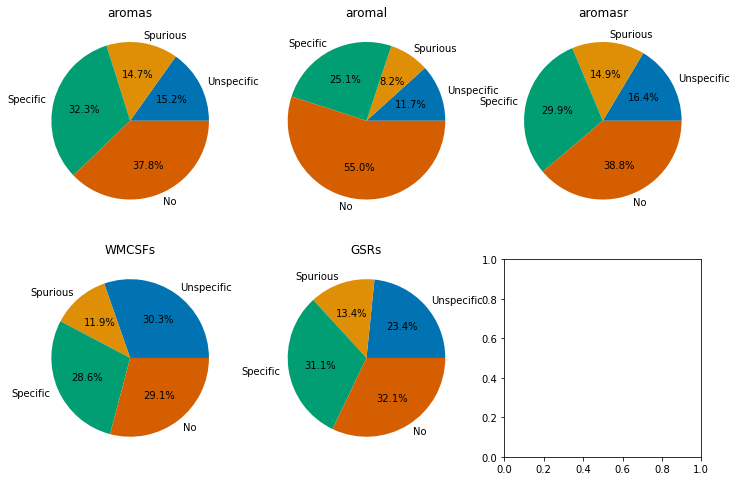

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,8))

sns.set_palette("colorblind")

ax1 = df_exclude['aromas_S1bf_cat'].value_counts(sort=False).plot.pie(title='aromas',ax=axes[0,0], autopct="%.1f%%")
ax2 = df_exclude['aromal_S1bf_cat'].value_counts(sort=False).plot.pie(title='aromal',ax=axes[0,1],autopct="%.1f%%")    
ax3 = df_exclude['aromasr_S1bf_cat'].value_counts(sort=False).plot.pie(title='aromasr',ax=axes[0,2],autopct="%.1f%%")    
ax4 = df_exclude['WMCSFs_S1bf_cat'].value_counts(sort=False).plot.pie(title='WMCSFs',ax=axes[1,0],autopct="%.1f%%")    
ax5 = df_exclude['GSRs_S1bf_cat'].value_counts(sort=False).plot.pie(title='GSRs',ax=axes[1,1],autopct="%.1f%%")    


ax1.set(xlabel="", ylabel="")
ax2.set(xlabel="", ylabel="")
ax3.set(xlabel="", ylabel="")
ax4.set(xlabel="", ylabel="")
ax5.set(xlabel="", ylabel="")


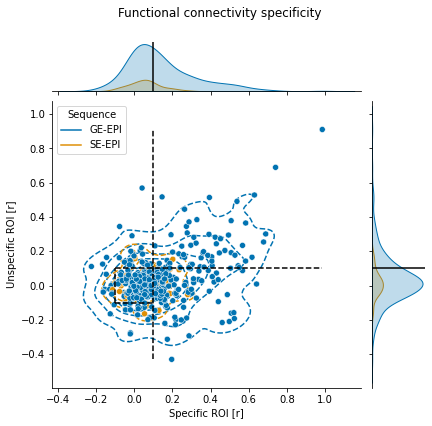

In [29]:
ax6 = sns.jointplot(data=df_exclude, x='aromas_S1bf_S1bf', y='aromas_S1bf_ACA', hue='func.sequence')
ax6.plot_joint(sns.kdeplot,linestyles='dashed', zorder=0, levels=6)

ax6.fig.suptitle('Functional connectivity specificity')
ax6.fig.subplots_adjust(top=0.9)
ax6.ax_joint.set(xlabel='Specific ROI [r]', ylabel='Unspecific ROI [r]')
ax6.ax_joint.get_legend().set_title('Sequence')
ax6.ax_joint.vlines(0.1,ymin=min(df_exclude['aromas_S1bf_ACA']),ymax=max(df_exclude['aromas_S1bf_ACA']),linestyles='dashed', color='black')
ax6.ax_joint.vlines(-0.1, -0.1,0.1,linestyles='dashed', color='black')
ax6.ax_joint.hlines(-0.1, -0.1,0.1,linestyles='dashed', color='black')
ax6.ax_joint.hlines(0.1, -0.1,xmax=max(df_exclude['aromas_S1bf_S1bf']),linestyles='dashed', color='black')
ax6.ax_marg_x.axvline(x=0.1, color='black')
ax6.ax_marg_y.axhline(y=0.1, color='black')

## ---- Plotting specific FC examples

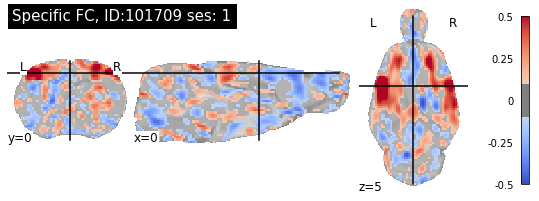

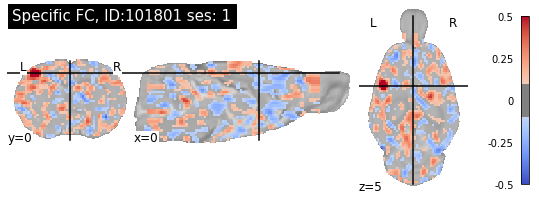

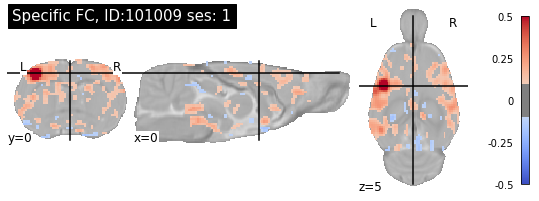

In [30]:
from nilearn import plotting
bg_img=os.path.join(analysis_folder, 
             'template',
             'SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1',
             'SIGMA_Rat_Anatomical_Imaging',
            'SIGMA_Rat_Anatomical_InVivo_Template',
            'SIGMA_InVivo_Brain_Template_Masked.nii')

import re
df_specific = df_exclude[['rat.sub','rat.ses']][df_exclude['aromas_S1bf_cat']=='Specific'].sample(n = 3)

for i in list(range(0,df_specific.shape[0])):
    r = re.compile('/aromas/')
    seed_list_sub=list(filter(r.findall, seed_list))
    r = re.compile('S1bf')
    seed_list_sub=list(filter(r.findall, seed_list_sub))
    r = re.compile(df_specific['rat.sub'].iloc[i].astype(str))
    seed_list_sub=list(filter(r.findall, seed_list_sub))
    r = re.compile('ses-'+df_specific['rat.ses'].iloc[i].astype(str))
    seed_list_sub=list(filter(r.findall, seed_list_sub))


    plotting.plot_stat_map(seed_list_sub[0], 
                           bg_img, 
                           title='Specific FC, ID:'+
                                df_specific['rat.sub'].iloc[i].astype(str)+
                                ' ses: '+
                                df_specific['rat.ses'].iloc[i].astype(str),
                           threshold=0.1,
                           vmax=0.5,
                           symmetric_cbar=True,
                           cmap='coolwarm',
                           black_bg=False,
                           #display_mode="y",
                           cut_coords=(0,0.14,5))

## ---- Plotting unspecific FC examples

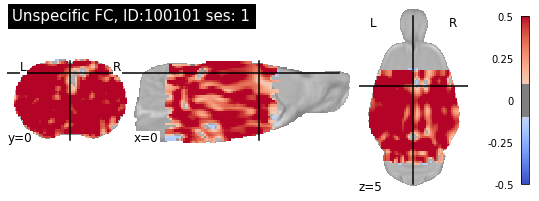

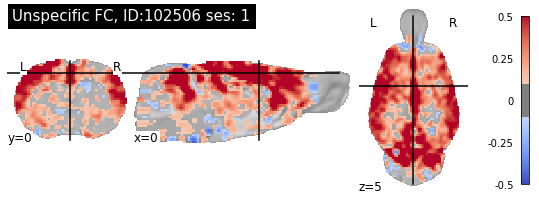

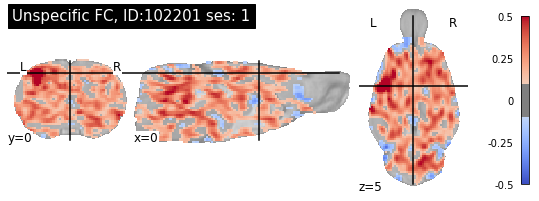

In [31]:
import re
df_specific = df_exclude[['rat.sub','rat.ses']][df_exclude['aromas_S1bf_cat']=='Unspecific'].sample(n = 3)

for i in list(range(0,df_specific.shape[0])):
    r = re.compile('/aromas/')
    seed_list_sub=list(filter(r.findall, seed_list))
    r = re.compile('S1bf')
    seed_list_sub=list(filter(r.findall, seed_list_sub))
    r = re.compile(df_specific['rat.sub'].iloc[i].astype(str))
    seed_list_sub=list(filter(r.findall, seed_list_sub))
    r = re.compile('ses-'+df_specific['rat.ses'].iloc[i].astype(str))
    seed_list_sub=list(filter(r.findall, seed_list_sub))


    plotting.plot_stat_map(seed_list_sub[0], 
                           bg_img, 
                           title='Unspecific FC, ID:'+
                                df_specific['rat.sub'].iloc[i].astype(str)+
                                ' ses: '+
                                df_specific['rat.ses'].iloc[i].astype(str),
                           threshold=0.1,
                           vmax=0.5,
                           symmetric_cbar=True,
                           cmap='coolwarm',
                           black_bg=False,
                           #display_mode="y",
                           cut_coords=(0,0.14,5))

## ---- Plotting no FC examples

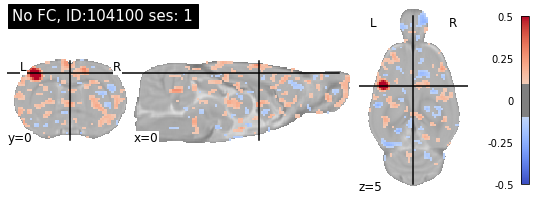

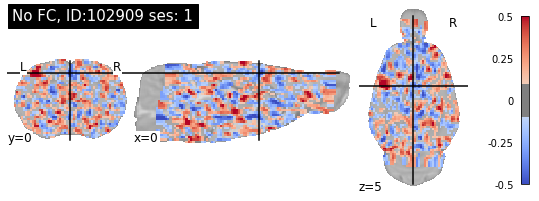

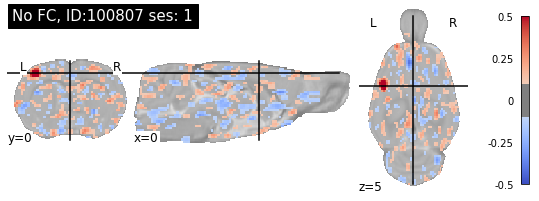

In [32]:
import re
df_specific = df_exclude[['rat.sub','rat.ses']][df_exclude['aromas_S1bf_cat']=='No'].sample(n = 3)

for i in list(range(0,df_specific.shape[0])):
    r = re.compile('/aromas/')
    seed_list_sub=list(filter(r.findall, seed_list))
    r = re.compile('S1bf')
    seed_list_sub=list(filter(r.findall, seed_list_sub))
    r = re.compile(df_specific['rat.sub'].iloc[i].astype(str))
    seed_list_sub=list(filter(r.findall, seed_list_sub))
    r = re.compile('ses-'+df_specific['rat.ses'].iloc[i].astype(str))
    seed_list_sub=list(filter(r.findall, seed_list_sub))


    plotting.plot_stat_map(seed_list_sub[0], 
                           bg_img, 
                           title='No FC, ID:'+
                                df_specific['rat.sub'].iloc[i].astype(str)+
                                ' ses: '+
                                df_specific['rat.ses'].iloc[i].astype(str),
                           threshold=0.1,
                           vmax=0.5,
                           symmetric_cbar=True,
                           cmap='coolwarm',
                           black_bg=False,
                           #display_mode="y",
                           cut_coords=(0,0.14,5))

## ---- Plotting Spurious FC examples

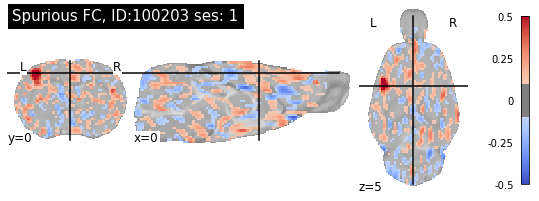

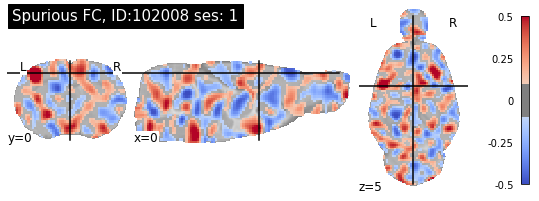

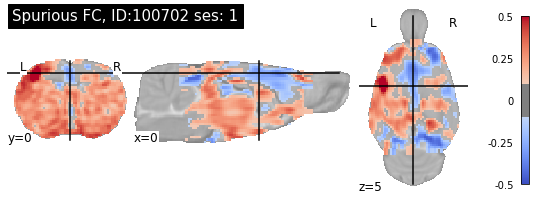

In [33]:
import re
df_specific = df_exclude[['rat.sub','rat.ses']][df_exclude['aromas_S1bf_cat']=='Spurious'].sample(n = 3)

for i in list(range(0,df_specific.shape[0])):
    r = re.compile('/aromas/')
    seed_list_sub=list(filter(r.findall, seed_list))
    r = re.compile('S1bf')
    seed_list_sub=list(filter(r.findall, seed_list_sub))
    r = re.compile(df_specific['rat.sub'].iloc[i].astype(str))
    seed_list_sub=list(filter(r.findall, seed_list_sub))
    r = re.compile('ses-'+df_specific['rat.ses'].iloc[i].astype(str))
    seed_list_sub=list(filter(r.findall, seed_list_sub))


    plotting.plot_stat_map(seed_list_sub[0], 
                           bg_img, 
                           title='Spurious FC, ID:'+
                                df_specific['rat.sub'].iloc[i].astype(str)+
                                ' ses: '+
                                df_specific['rat.ses'].iloc[i].astype(str),
                           threshold=0.1,
                           vmax=0.5,
                           symmetric_cbar=True,
                           cmap='coolwarm',
                           black_bg=False,
                           #display_mode="y",
                           cut_coords=(0,0.14,5))

## Now doing a Chi2 test to see distribution of specificity among variables

From preregistration: 
"Specificity: parameter associated with connectivity specificity. 
Assuming S1 and Cg belong to distinct anti- (or minimally-) correlated networks, FC specificity will be determined the 4 quadrant system in Grandjean et al 2020. A ??2 test will be used to determine which factors (field strength, coil design, anesthesia, strain, gender) have a skewed distribution of specific FC. "

In [45]:
from scipy.stats import chi2_contingency

# now testing strain
chi_stack = df_exclude.groupby(['rat.strain', 
                    'aromas_S1bf_cat']).size().unstack('aromas_S1bf_cat')
chi_stack = chi_stack.fillna(0)
print('')
g, p, dof, expctd  = chi2_contingency(chi_stack)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)
print(chi_stack.sort_values(by="Specific_percent",ascending=False))
print('Strain effect: g-value = '+str(g)+' dof = '+str(dof)+' p-value = '+str(p))

# now testing sex
chi_stack = df_exclude.groupby(['rat.sex', 
                    'aromas_S1bf_cat']).size().unstack('aromas_S1bf_cat')
chi_stack = chi_stack.fillna(0)
print('')
g, p, dof, expctd  = chi2_contingency(chi_stack)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)
print(chi_stack.sort_values(by="Specific_percent",ascending=False))
print('Sex effect: g-value = '+str(g)+' dof = '+str(dof)+' p-value = '+str(p))

# now testing age
chi_stack = df_exclude.groupby(['rat.age', 
                    'aromas_S1bf_cat']).size().unstack('aromas_S1bf_cat')
chi_stack = chi_stack.fillna(0)
print('')
g, p, dof, expctd  = chi2_contingency(chi_stack)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)
print(chi_stack.sort_values(by="Specific_percent",ascending=False))
print('Age effect: g-value = '+str(g)+' dof = '+str(dof)+' p-value = '+str(p))

# now testing anesthesia.maintenance
chi_stack = df_exclude.groupby(['anesthesia.maintenance', 
                    'aromas_S1bf_cat']).size().unstack('aromas_S1bf_cat')
chi_stack = chi_stack.fillna(0)
print('')
g, p, dof, expctd  = chi2_contingency(chi_stack)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)
print(chi_stack.sort_values(by="Specific_percent",ascending=False))
print('Anesthesia effect: g-value = '+str(g)+' dof = '+str(dof)+' p-value = '+str(p))

# now testing anesthesia.breathing.assistance
chi_stack = df_exclude.groupby(['anesthesia.breathing.assistance', 
                    'aromas_S1bf_cat']).size().unstack('aromas_S1bf_cat')
chi_stack = chi_stack.fillna(0)
print('')
g, p, dof, expctd  = chi2_contingency(chi_stack)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)
print(chi_stack.sort_values(by="Specific_percent",ascending=False))
print('Breathing assistance effect: g-value = '+str(g)+' dof = '+str(dof)+' p-value = '+str(p))


# now testing field strength
chi_stack = df_exclude.groupby(['MRI.field.strength', 
                    'aromas_S1bf_cat']).size().unstack('aromas_S1bf_cat')
chi_stack = chi_stack.fillna(0)
print('')
g, p, dof, expctd  = chi2_contingency(chi_stack)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)
print(chi_stack.sort_values(by="Specific_percent",ascending=False))
print('Field strength effect: g-value = '+str(g)+' dof = '+str(dof)+' p-value = '+str(p))

# now testing sequence
chi_stack = df_exclude.groupby(['func.sequence', 
                    'aromas_S1bf_cat']).size().unstack('aromas_S1bf_cat')
chi_stack = chi_stack.fillna(0)
print('')
g, p, dof, expctd  = chi2_contingency(chi_stack)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)
print(chi_stack.sort_values(by="Specific_percent",ascending=False))
print('Sequence effect: g-value = '+str(g)+' dof = '+str(dof)+' p-value = '+str(p))


aromas_S1bf_cat    No  Specific  Spurious  Unspecific    sum  Specific_percent
rat.strain                                                                    
Lister Hooded     1.0       6.0       3.0         0.0   10.0              0.60
Wistar           60.0      55.0      31.0        18.0  164.0              0.34
Sprague Dawley   35.0      34.0       9.0        25.0  103.0              0.33
Fischer 344      31.0      19.0       5.0         4.0   59.0              0.32
Long Evans       25.0      16.0      11.0        14.0   66.0              0.24
Strain effect: g-value = 30.849357646757213 dof = 12 p-value = 0.0020769067063305217

aromas_S1bf_cat   No  Specific  Spurious  Unspecific  sum  Specific_percent
rat.sex                                                                    
Male             100       100        45          56  301              0.33
Female            52        30        14           5  101              0.30
Sex effect: g-value = 16.312954902232146 dof = 3 p-value

In [46]:
# check how datasets are prefroming
chi_stack = df_exclude.groupby(['rat.ds', 
                    'aromas_S1bf_cat']).size().unstack('aromas_S1bf_cat')
chi_stack = chi_stack.fillna(0)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)

print("FC specificity distribution per dataset, armoas denoising")
print(chi_stack["Specific_percent"].quantile([0.25,0.5,0.75]))
chi_stack.sort_values(by="Specific_percent",ascending=False)


FC specificity distribution per dataset, armoas denoising
0.25    0.200
0.50    0.300
0.75    0.435
Name: Specific_percent, dtype: float64


aromas_S1bf_cat   No  Specific  Spurious  Unspecific   sum  Specific_percent
rat.ds                                                                      
1015             0.0       7.0       0.0         2.0   9.0              0.78
1022             0.0       7.0       0.0         3.0  10.0              0.70
1017             0.0       7.0       1.0         2.0  10.0              0.70
1035             2.0       6.0       0.0         1.0   9.0              0.67
1031             3.0       6.0       0.0         0.0   9.0              0.67
1020             1.0       6.0       3.0         0.0  10.0              0.60
1024             2.0       5.0       0.0         3.0  10.0              0.50
1028             2.0       5.0       3.0         0.0  10.0              0.50
1034             3.0       5.0       0.0         2.0  10.0              0.50
1005             0.0       4.0       0.0         5.0   9.0              0.44
1040             4.0       4.0       1.0         0.0   9.0              0.44
1039             3.0       3.0       0.0         1.0   7.0              0.43
1006             4.0       4.0       2.0         0.0  10.0              0.40
1009             5.0       4.0       0.0         1.0  10.0              0.40
1004             5.0       4.0       0.0         1.0  10.0              0.40
1016             0.0       4.0       5.0         1.0  10.0              0.40
1032             4.0       4.0       2.0         0.0  10.0              0.40
1037             4.0       3.0       2.0         0.0   9.0              0.33
1010             5.0       3.0       1.0         0.0   9.0              0.33
1019             6.0       3.0       0.0         0.0   9.0              0.33
1033             0.0       3.0       0.0         7.0  10.0              0.30
1014             4.0       3.0       1.0         2.0  10.0              0.30
1018             5.0       3.0       2.0         0.0  10.0              0.30
1030             3.0       3.0       4.0         0.0  10.0              0.30
1036             0.0       2.0       3.0         2.0   7.0              0.29
1013             1.0       1.0       2.0         0.0   4.0              0.25
1026             1.0       2.0       0.0         5.0   8.0              0.25
1043             4.0       2.0       3.0         0.0   9.0              0.22
1025             3.0       2.0       0.0         5.0  10.0              0.20
1002             1.0       2.0       6.0         1.0  10.0              0.20
1021             7.0       2.0       1.0         0.0  10.0              0.20
1012             7.0       2.0       1.0         0.0  10.0              0.20
1007             4.0       2.0       3.0         1.0  10.0              0.20
1027             8.0       1.0       0.0         0.0   9.0              0.11
1038             5.0       1.0       3.0         0.0   9.0              0.11
1011             7.0       1.0       2.0         0.0  10.0              0.10
1003             7.0       1.0       0.0         2.0  10.0              0.10
1041             9.0       1.0       0.0         0.0  10.0              0.10
1042             9.0       1.0       0.0         0.0  10.0              0.10
1001             1.0       1.0       3.0         5.0  10.0              0.10
1029             6.0       0.0       2.0         1.0   9.0              0.00
1023             0.0       0.0       0.0         8.0   8.0              0.00
1008             7.0       0.0       3.0         0.0  10.0              0.00

## Now looking at FC sensitivity

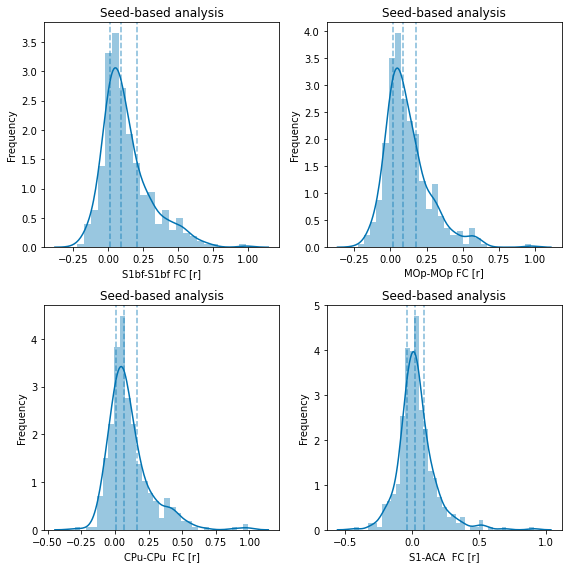

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
sns.set_palette("colorblind")

ax1 = sns.distplot(df_exclude['aromas_S1bf_S1bf'],ax=axes[0,0])
ax2 = sns.distplot(df_exclude['aromas_MOp_MOp'],ax=axes[0,1])
ax3 = sns.distplot(df_exclude['aromas_CPu_CPu'],ax=axes[1,0])
ax4 = sns.distplot(df_exclude['aromas_S1bf_ACA'],ax=axes[1,1])

ax1.set(xlabel='S1bf-S1bf FC [r]', ylabel='Frequency', title='Seed-based analysis')
ax2.set(xlabel='MOp-MOp FC [r]', ylabel='Frequency', title='Seed-based analysis')
ax3.set(xlabel='CPu-CPu  FC [r]', ylabel='Frequency', title='Seed-based analysis')
ax4.set(xlabel='S1-ACA  FC [r]', ylabel='Frequency', title='Seed-based analysis')

ax1.axvline(df_exclude['aromas_S1bf_S1bf'].quantile(0.25),ls='--',alpha=0.5)
ax1.axvline(df_exclude['aromas_S1bf_S1bf'].quantile(0.50),ls='--',alpha=0.5)
ax1.axvline(df_exclude['aromas_S1bf_S1bf'].quantile(0.75),ls='--',alpha=0.5)

ax2.axvline(df_exclude['aromas_MOp_MOp'].quantile(0.25),ls='--',alpha=0.5)
ax2.axvline(df_exclude['aromas_MOp_MOp'].quantile(0.50),ls='--',alpha=0.5)
ax2.axvline(df_exclude['aromas_MOp_MOp'].quantile(0.75),ls='--',alpha=0.5)


ax3.axvline(df_exclude['aromas_CPu_CPu'].quantile(0.25),ls='--',alpha=0.5)
ax3.axvline(df_exclude['aromas_CPu_CPu'].quantile(0.50),ls='--',alpha=0.5)
ax3.axvline(df_exclude['aromas_CPu_CPu'].quantile(0.75),ls='--',alpha=0.5)

ax4.axvline(df_exclude['aromas_S1bf_ACA'].quantile(0.25),ls='--',alpha=0.5)
ax4.axvline(df_exclude['aromas_S1bf_ACA'].quantile(0.50),ls='--',alpha=0.5)
ax4.axvline(df_exclude['aromas_S1bf_ACA'].quantile(0.75),ls='--',alpha=0.5)


plt.tight_layout()

In [48]:
#extracting quartiles for the functional connectivity parameters
df_exclude[['aromas_S1bf_S1bf','aromas_MOp_MOp','aromas_CPu_CPu','aromas_S1bf_ACA']].quantile([0.25,0.5,0.75])

aromas_S1bf_S1bf  aromas_MOp_MOp  aromas_CPu_CPu  aromas_S1bf_ACA
0.25          0.014888        0.018401        0.005412        -0.040633
0.50          0.088508        0.084464        0.067535         0.019247
0.75          0.201822        0.179565        0.162290         0.089021

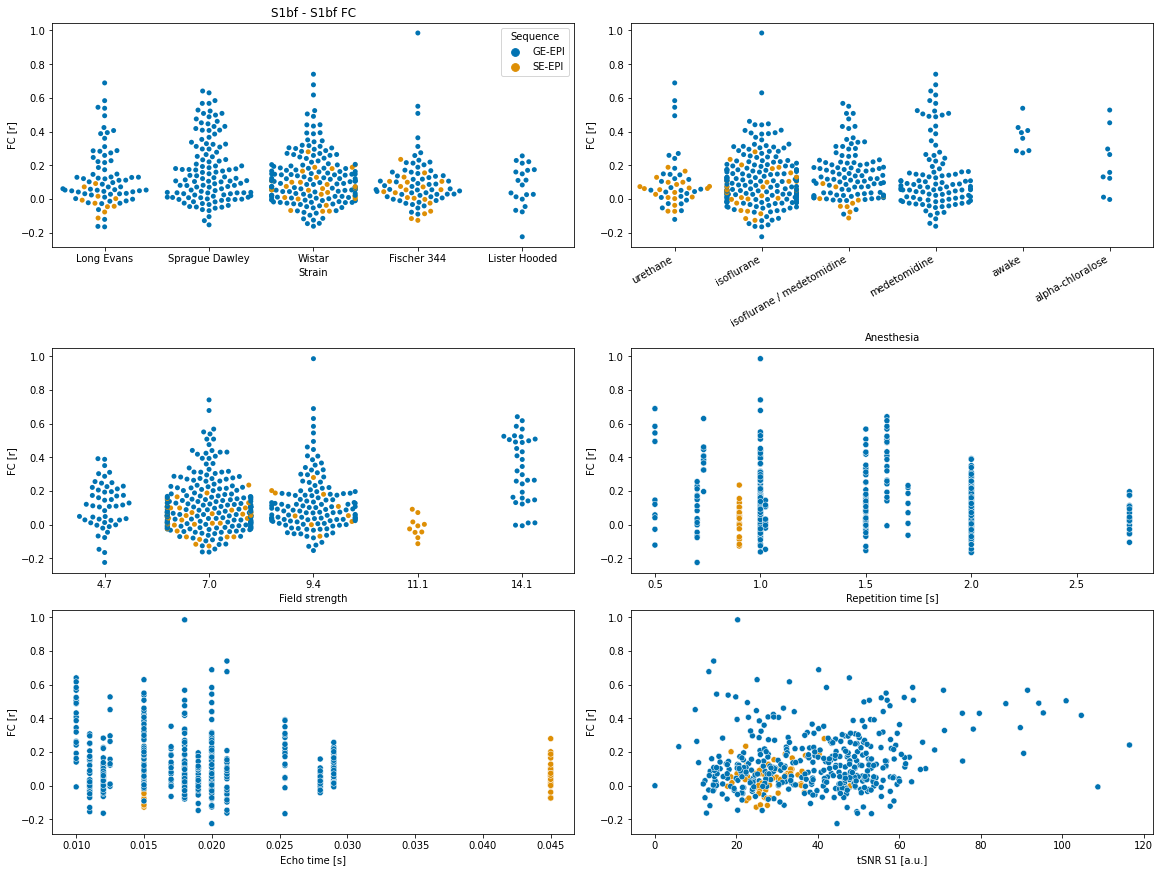

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
#plotting as a function of different parameters

fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(16, 12),constrained_layout=True)


sns.set_palette("colorblind")
df_exclude = df.loc[(df['exclude'] != 'yes')]

ax0 = sns.swarmplot(data=df_exclude, x="rat.strain",
                    y="aromas_S1bf_S1bf", hue="func.sequence",ax=axes[0,0])
ax1 = sns.swarmplot(data=df_exclude, x="anesthesia.maintenance",
                    y="aromas_S1bf_S1bf", hue="func.sequence",ax=axes[0,1])
ax2 = sns.swarmplot(data=df_exclude, x="MRI.field.strength",
                    y="aromas_S1bf_S1bf", hue="func.sequence",ax=axes[1,0])
ax3 = sns.scatterplot(data=df_exclude, x="func.TR",
                    y="aromas_S1bf_S1bf", hue="func.sequence",ax=axes[1,1])
ax4 = sns.scatterplot(data=df_exclude, x="func.TE",
                    y="aromas_S1bf_S1bf", hue="func.sequence",ax=axes[2,0])
ax5 = sns.scatterplot(data=df_exclude, x="tsnr.S1",
                    y="aromas_S1bf_S1bf", hue="func.sequence",ax=axes[2,1])


ax0.set(xlabel='Strain', ylabel='FC [r]', title='S1bf - S1bf FC')
ax0.get_legend().set_title('Sequence')

ax1.set(xlabel='Anesthesia', ylabel='FC [r]')
ax1.get_legend().remove()
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=30, ha='right')

ax2.set(xlabel='Field strength', ylabel='FC [r]')
ax2.get_legend().remove()

ax3.set(xlabel='Repetition time [s]', ylabel='FC [r]')
ax3.get_legend().remove()

ax4.set(xlabel='Echo time [s]', ylabel='FC [r]')
ax4.get_legend().remove()

ax5.set(xlabel='tSNR S1 [a.u.]', ylabel='FC [r]')
ax5.get_legend().remove()

#plt.constrained_layout()


In [39]:
df_sub = df_exclude[['aromas_S1bf_S1bf',
             'aromas_MOp_MOp',
             'aromas_CPu_CPu',
             'aromas_S1bf_ACA',
             'rat.sex',
             'rat.strain',
             'rat.age',
             'rat.weight',
             'exp.type',
             'anesthesia.maintenance',
            'anesthesia.breathing.rate',
            'anesthesia.heart.rate',
            'MRI.vendor',
            'MRI.field.strength',
            'func.sequence',
            'func.TR',
            'func.TE']]

df_sub['MRI.field.strength']=df_sub['MRI.field.strength'].astype('int')


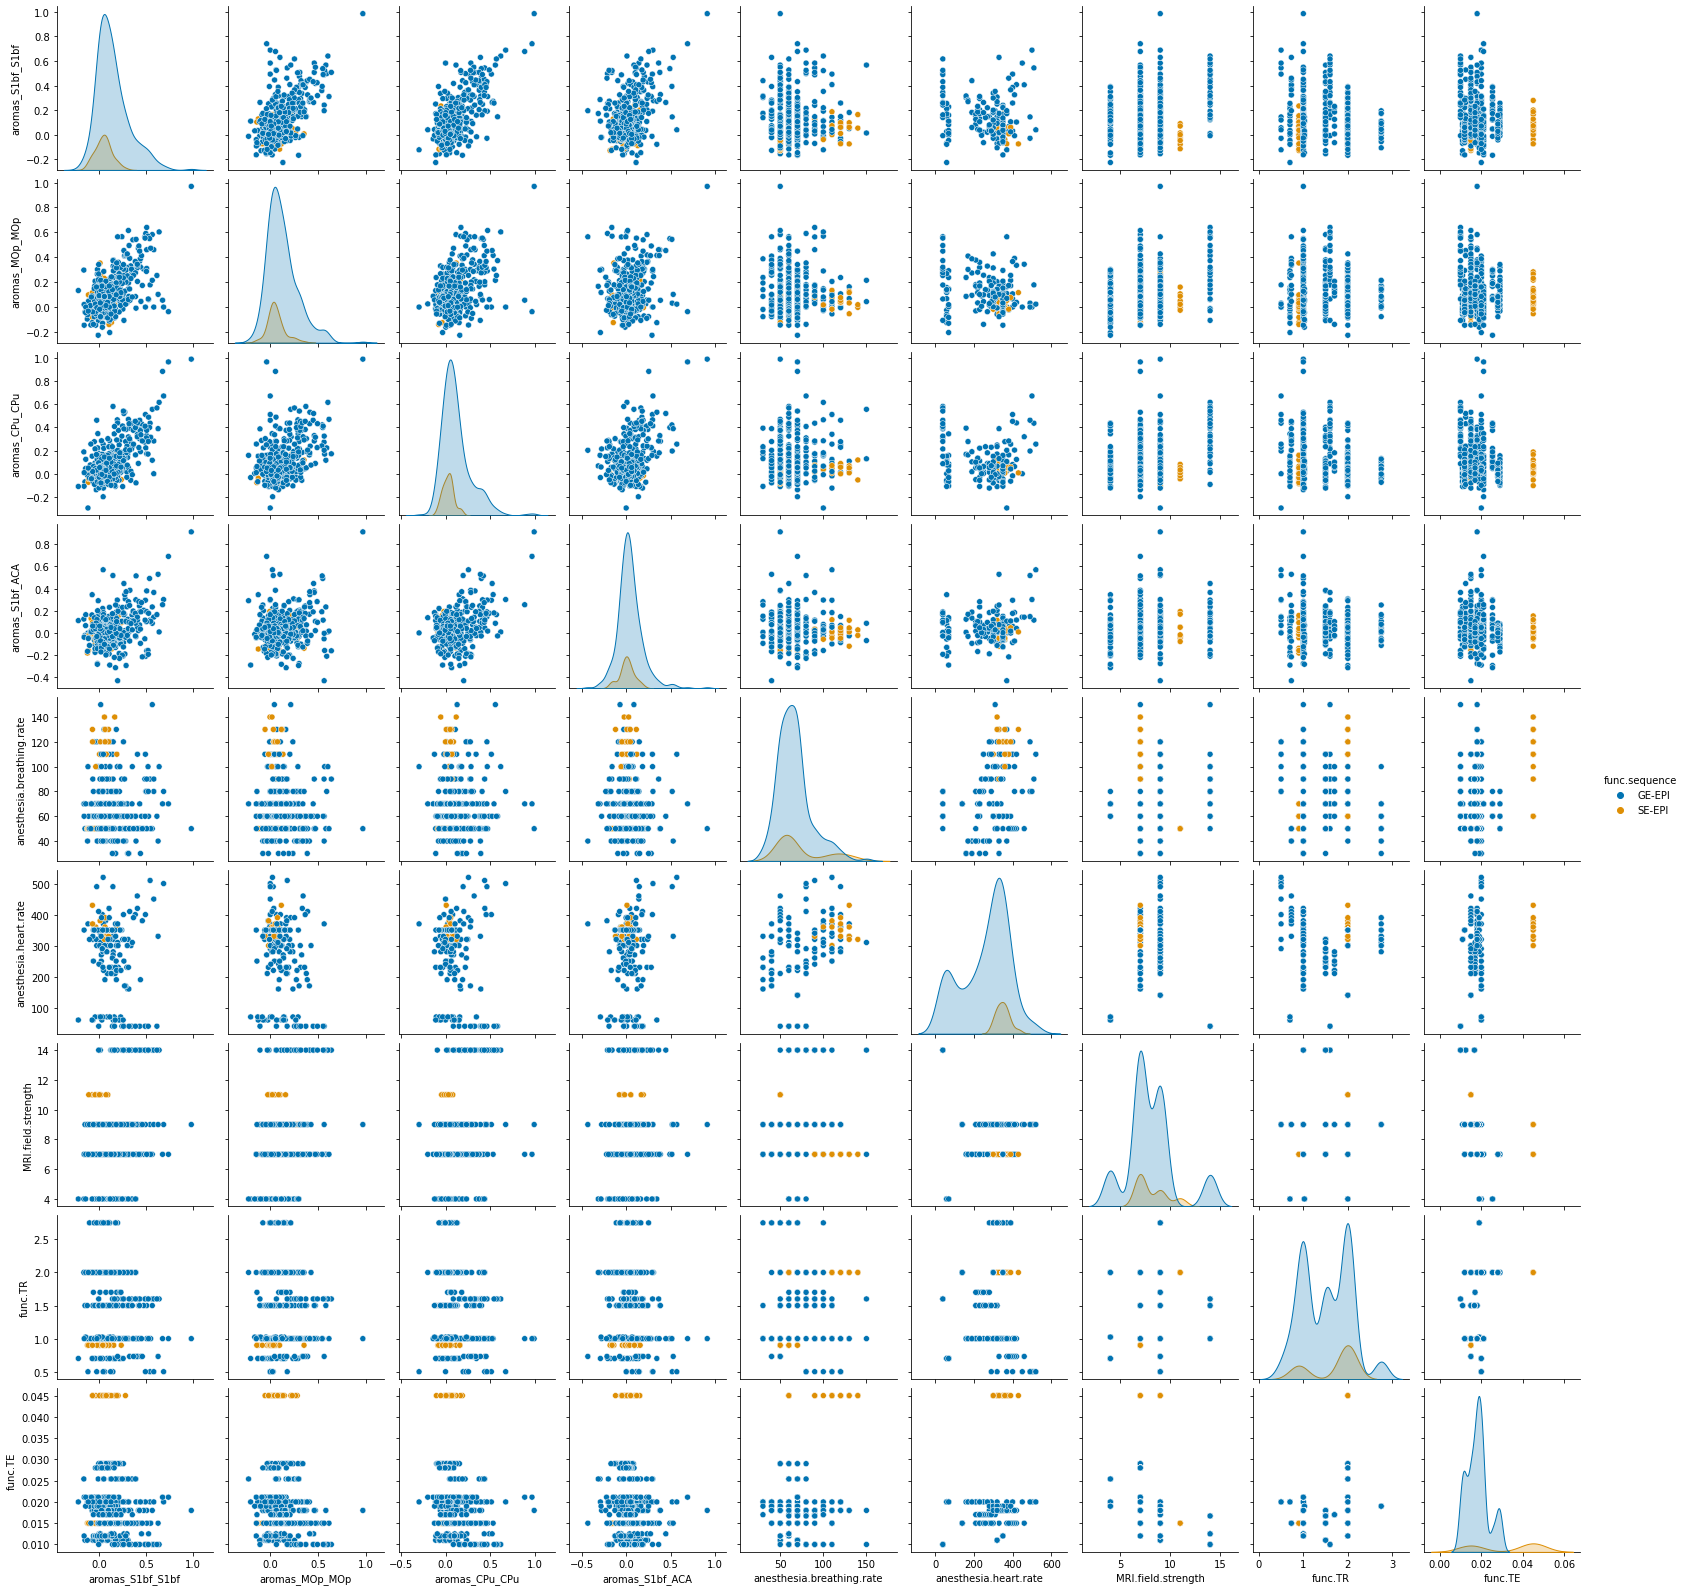

In [52]:
sns.pairplot(df_sub, hue="func.sequence")

From the preregistration: 
"Sensitivity: parameters associated with connectivity strength.
Functional connectivity (FC) between selected region of interest (S1 - S1, Cg - Rsp), or within ICA component (S1, Cg)  will be modeled into a linear model in statistical software R. Functional connectivity parameter will be modeled as a function of strain (factorial), gender (factorial), weight (ordered factorial), cortical signal-to-noise ratio (continuous), temporal cortical signal-to-noise (continuous, if not correlated to signal-to-noise ratio), mean framewise displacement. Significance will be assessed using an analysis of variance. P-value threshold will be set at p<0.05 without additional correction.  "

In [11]:
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

#because statsmodels doesn't like columns with dots. the stats were originally planned in R. :-( )
df_exclude.columns=df_exclude.columns.str.replace('[\.]', '')

# Full model
m01 = ols('aromas_S1bf_S1bf ~ ratstrain + ratsex + ratweight + tsnrS1 + MFW +anesthesiamaintenance', data=df_exclude).fit()
print(m01.summary())

print('testing for the effect of strain')
m02 = ols('aromas_S1bf_S1bf ~ ratsex + ratweight + tsnrS1 + MFW+anesthesiamaintenance', data=df_exclude).fit()
print(anova_lm(m02, m01))

print('')
print('testing for the effect of sex')
m02 = ols('aromas_S1bf_S1bf ~ ratstrain + ratweight + tsnrS1 + MFW+anesthesiamaintenance', data=df_exclude).fit()
print(anova_lm(m02, m01))

print('')
print('testing for the effect of weight')
m02 = ols('aromas_S1bf_S1bf ~ ratstrain + ratsex + tsnrS1 + MFW+anesthesiamaintenance', data=df_exclude).fit()
print(anova_lm(m02, m01))

print('')
print('testing for the effect of tSNR')
m02 = ols('aromas_S1bf_S1bf ~ ratstrain + ratsex + ratweight + MFW+anesthesiamaintenance', data=df_exclude).fit()
print(anova_lm(m02, m01))

print('')
print('testing for the effect of motion')
m02 = ols('aromas_S1bf_S1bf ~ ratstrain + ratsex + ratweight + tsnrS1+anesthesiamaintenance', data=df_exclude).fit()
print(anova_lm(m02, m01))

print('')
print('testing for the effect of anesthesia')
m02 = ols('aromas_S1bf_S1bf ~ ratstrain + ratsex + ratweight + tsnrS1 + MFW', data=df_exclude).fit()
print(anova_lm(m02, m01))


                            OLS Regression Results                            
Dep. Variable:       aromas_S1bf_S1bf   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     4.782
Date:                Fri, 09 Jul 2021   Prob (F-statistic):           1.52e-10
Time:                        11:35:35   Log-Likelihood:                 158.14
No. Observations:                 353   AIC:                            -272.3
Df Residuals:                     331   BIC:                            -187.2
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

## Group analysis. Estimating one sample t-test maps per datasets (session 1 exclusively). 
Images are exported as z-score image, thresholded z > 1.9 corresponding to p =< 0.05, one tailed, uncorrected (a very liberal threshold!) 

From preregistration: 
"Seed-based analysis voxel-wise analysis across the individual datasets
The seed-based analysis from the individual datasets (each consisting of n=10) will be examined with a more lenient parametric one-sample t-test (fsl_glm), without cluster correction and p-value threshold 0.05. This is to ensure that no FC is rejected (low false negative), but at the expense of a higher false-positive rate. The analysis across individual datasets will be summarized in an overlap map denoting the percentage of datasets reaching significance for each voxel. "


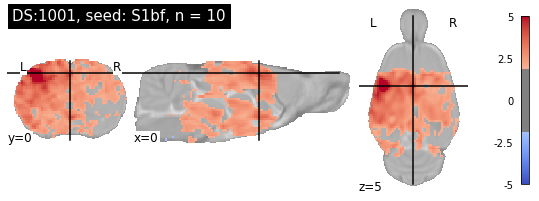

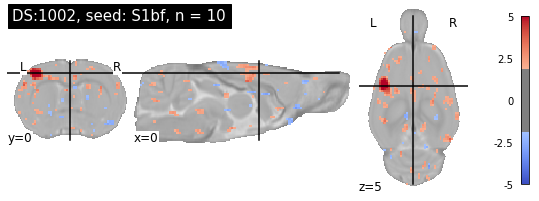

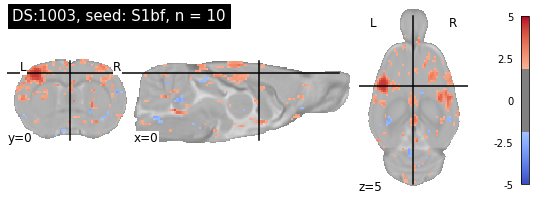

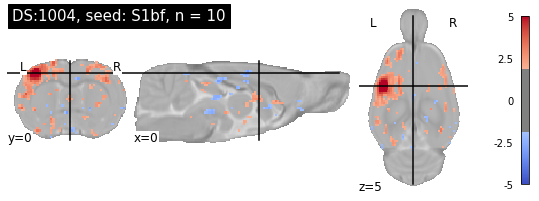

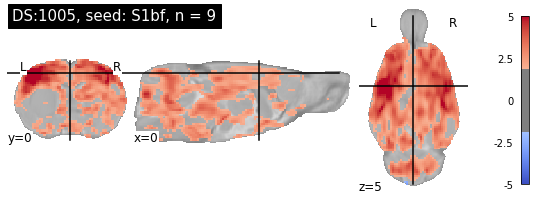

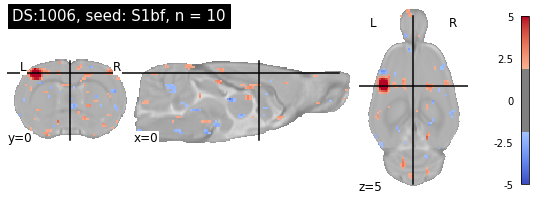

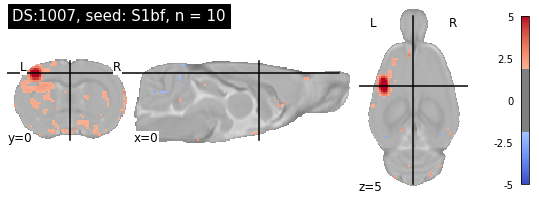

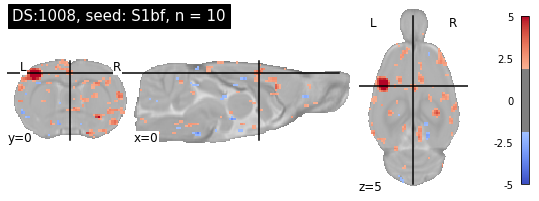

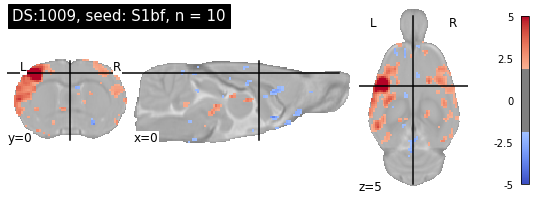

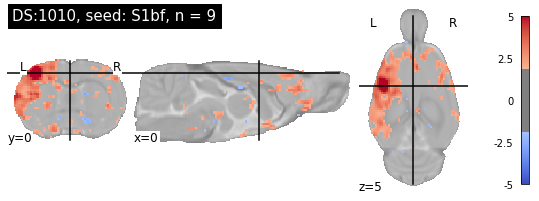

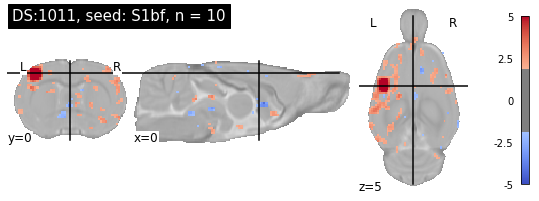

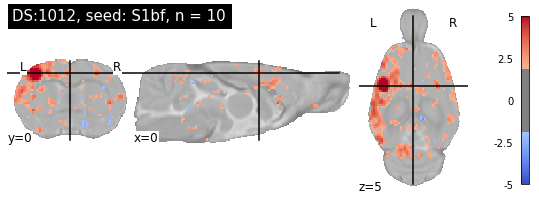

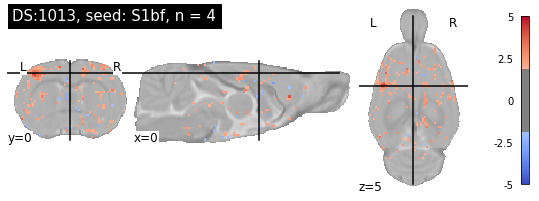

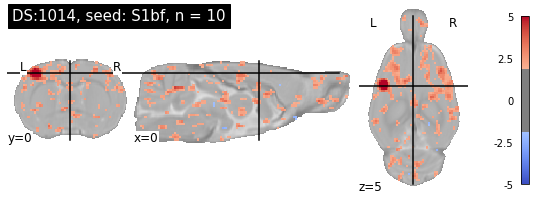

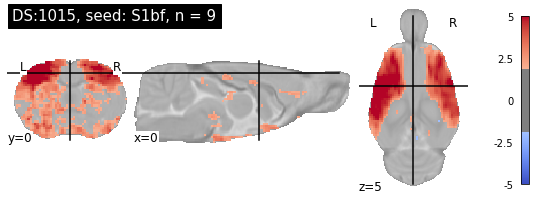

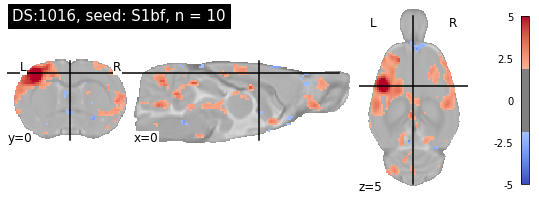

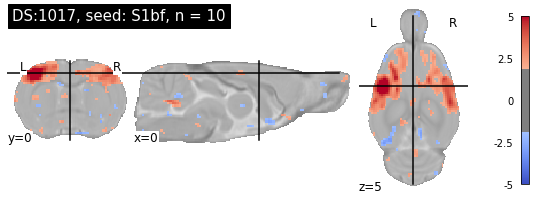

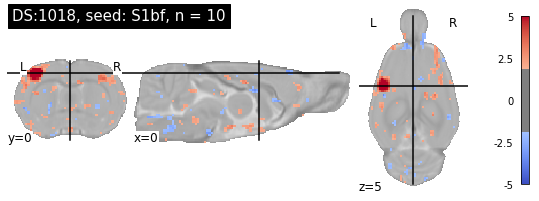

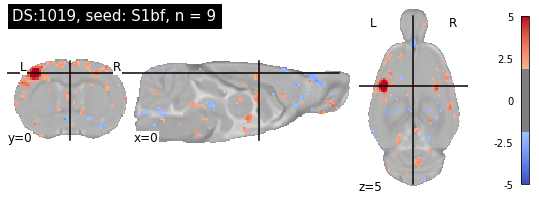

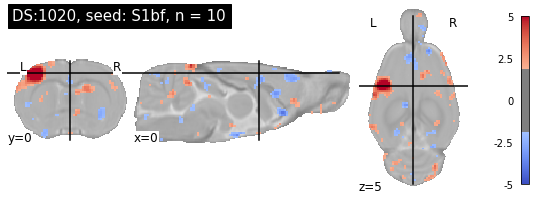

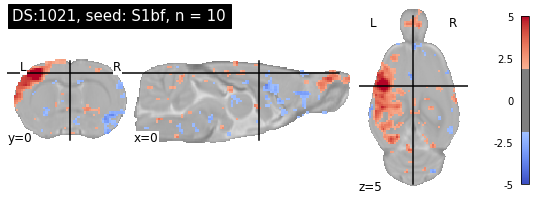

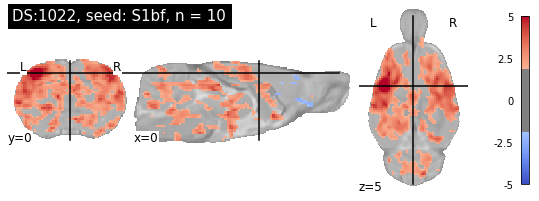

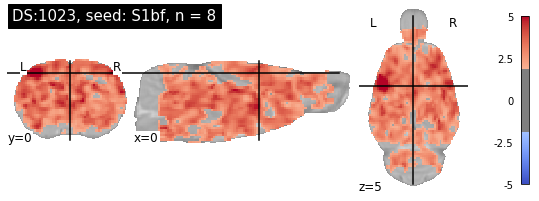

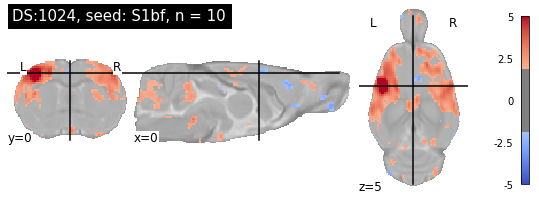

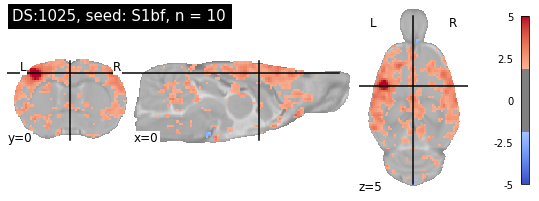

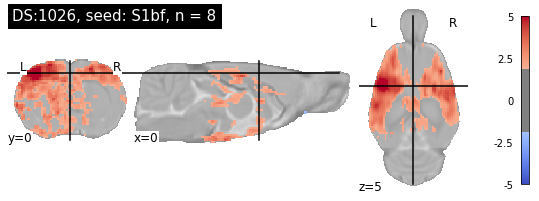

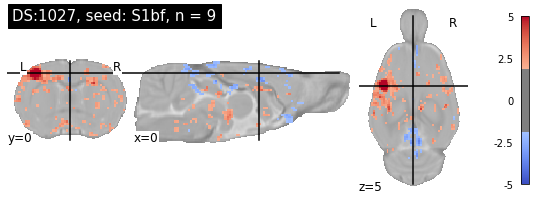

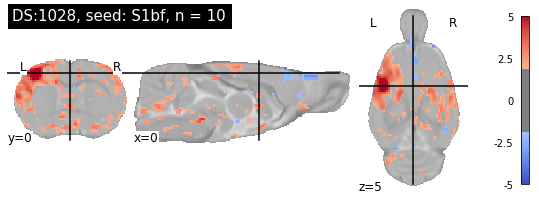

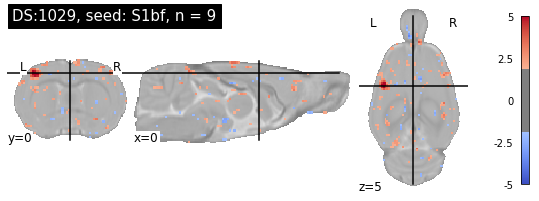

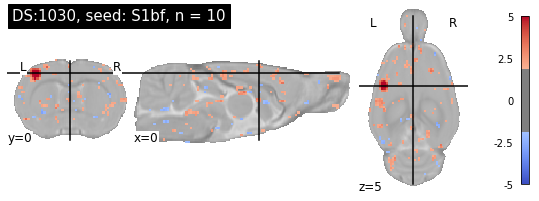

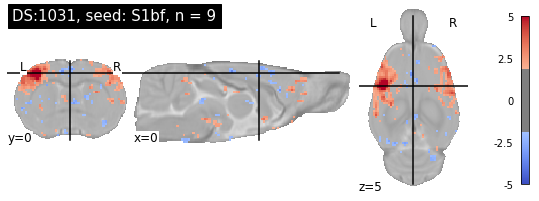

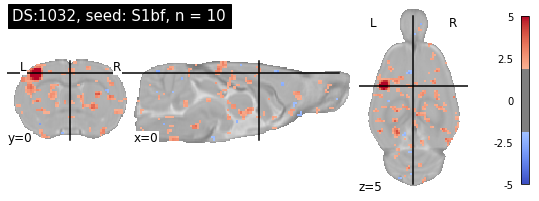

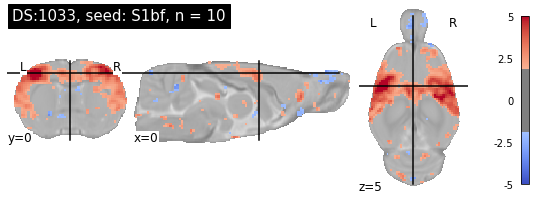

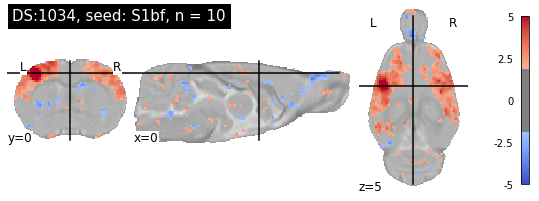

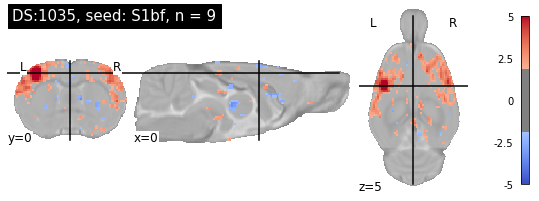

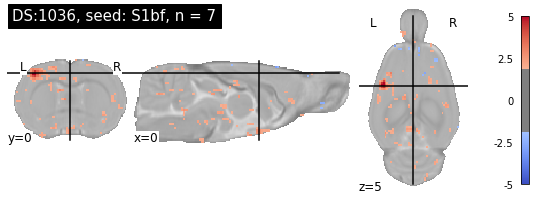

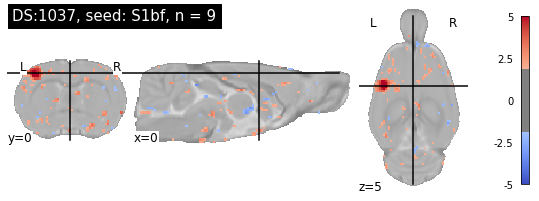

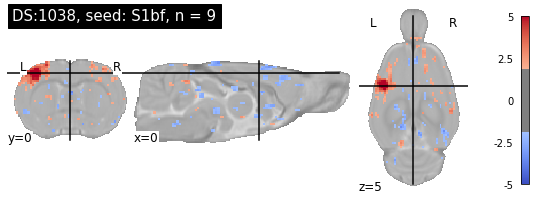

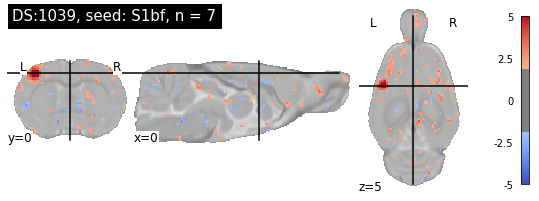

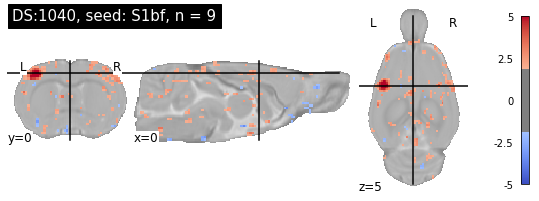

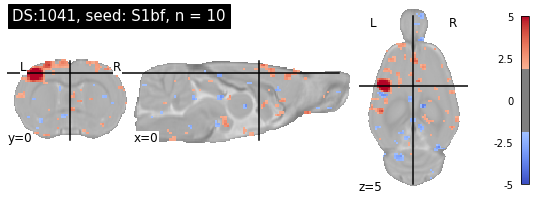

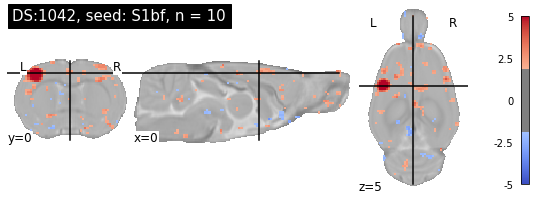

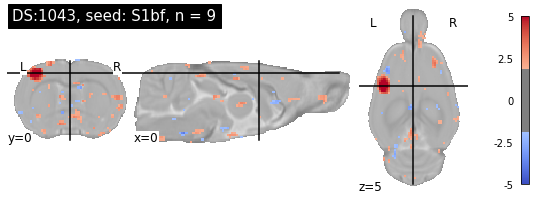

In [46]:
import re
from nilearn.glm.second_level import SecondLevelModel
from nilearn.plotting import plot_stat_map
import matplotlib.pyplot as plt
import pandas as pd


bg_img = os.path.join(analysis_folder,
                      'template',
                      'SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1',
                      'SIGMA_Rat_Anatomical_Imaging',
                      'SIGMA_Rat_Anatomical_InVivo_Template',
                      'SIGMA_InVivo_Brain_Template_Masked.nii')

# output folders
output_nii = os.path.join(analysis_folder, 'scratch', 'group_SBA')
output_img = os.path.join(analysis_folder, 'scratch', 'group_SBA_img')
os.makedirs(output_nii, exist_ok=True)
os.makedirs(output_img, exist_ok=True)

# re-read the table
df_exclude = df.loc[(df['exclude'] != 'yes')].loc[(
    df['exp.type'] == 'resting-state')].loc[(df['rat.ses']) == 1]

# re-read all seed files in the path.
condtion = 'aromas'
seed_list = glob.glob(
    (os.path.join(analysis_folder, 'scratch', 'seed', condtion))+'/*')
seed_group = ['S1bf','ACA', 'CPu','MOp']
y_stack = [0.14, 2.2, 1.6, 3.1]

for i in list(df_exclude['rat.ds'].unique()):
    for count, seed in enumerate(seed_group):

        r = re.compile(seed)
        seed_list_sub = list(filter(r.findall, seed_list))
        r = re.compile(str(i))
        seed_list_sub = list(filter(r.findall, seed_list_sub))
        r = re.compile('ses-1')
        seed_list_sub = list(filter(r.findall, seed_list_sub))
        r = re.compile("(?=(" + "|".join(map(re.escape, map(str,
               df_exclude['rat.sub'].loc[(df_exclude['rat.ds'] == i)]))) + "))")
        seed_list_sub = list(filter(r.findall, seed_list_sub))



        second_level_input = seed_list_sub
        design_matrix = pd.DataFrame([1] * len(second_level_input),
                             columns=['intercept'])


        second_level_model = SecondLevelModel()
        second_level_model = second_level_model.fit(second_level_input,
                                            design_matrix=design_matrix)

        z_map = second_level_model.compute_contrast(output_type='z_score')

        filename_export = 'DS-'+str(i)+"_seed-"+seed
        filename_path = os.path.join(
            analysis_folder, 'scratch', output_nii, filename_export)

        z_map.to_filename(filename_path+'.nii.gz')

        filename_path = os.path.join(
            analysis_folder, 'scratch', output_img, filename_export)
        plot_stat_map(z_map,
              bg_img,
              title='DS:' + str(i) +
              ', seed: ' + seed + ', n = '+ str(len(second_level_input)),
              threshold=1.9,
              vmax=5,
              symmetric_cbar=True,
              cmap='coolwarm',
              black_bg=False,
              # display_mode="y",
              cut_coords=(0, y_stack[count], 5),
              output_file=filename_path+'.svg')
        #remake plot with output to jupyter notebook if S1bf seed
        if(seed == 'S1bf'):
            plot_stat_map(z_map,
              bg_img,
              title='DS:' + str(i) +
              ', seed: ' + seed + ', n = '+ str(len(second_level_input)),
              threshold=1.9,
              vmax=5,
              symmetric_cbar=True,
              cmap='coolwarm',
              black_bg=False,
              # display_mode="y",
              cut_coords=(0, y_stack[count], 5))

## Estimate incidence maps
Load one-sample t-test, threshold and perform mean across 4th dimension. 


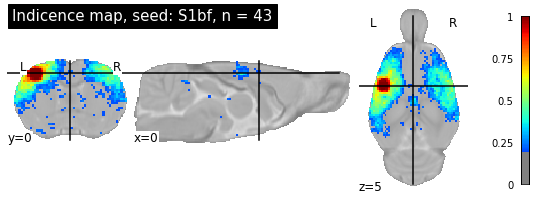

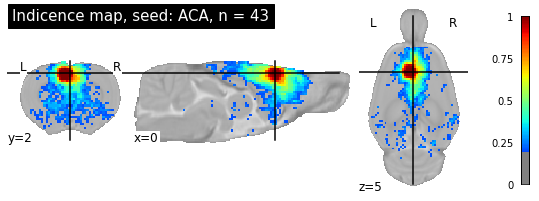

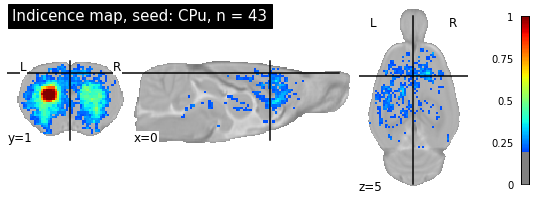

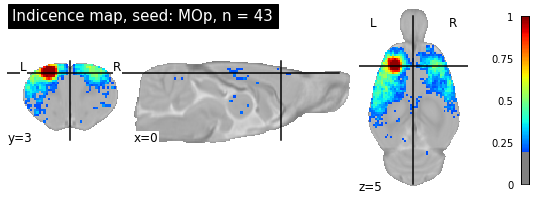

In [83]:
import re
from nilearn.image import concat_imgs, threshold_img,math_img
from nilearn.plotting import plot_stat_map
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# combine jet colormap for plot_stat_map (see https://stackoverflow.com/a/31052741)
# select to color scheme to use
colors1 = plt.cm.jet(np.linspace(0., 1, 128))
colors = np.vstack((colors1, colors1))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)


bg_img = os.path.join(analysis_folder,
                      'template',
                      'SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1',
                      'SIGMA_Rat_Anatomical_Imaging',
                      'SIGMA_Rat_Anatomical_InVivo_Template',
                      'SIGMA_InVivo_Brain_Template_Masked.nii')

# output folders
output_incidence = os.path.join(analysis_folder, 'scratch', 'group_SBA_incidence')
os.makedirs(output_incidence, exist_ok=True)

# read all one sample t-test files in the path.
seed_list = glob.glob(
    (os.path.join(analysis_folder, 'scratch', 'group_SBA'))+'/*')
seed_group = ['S1bf','ACA', 'CPu','MOp']
y_stack = [0.14, 2.2, 1.6, 3.1]

for count,seed in enumerate(seed_group):

    filename_export = "seed-"+seed
    filename_path = os.path.join(analysis_folder, 'scratch', output_incidence, filename_export)

    r = re.compile(seed)
    seed_list_sub = list(filter(r.findall, seed_list))

    con_img = concat_imgs(seed_list_sub, auto_resample=True)
    th_img = math_img("img >=  1.9", img=con_img)
    ma_img = math_img("np.mean(img, axis=-1)", img=th_img)
    ma_img.to_filename(filename_path+'.nii.gz')

    #one for the save
    plot_stat_map(ma_img,
              bg_img,
              title='Indicence map, seed: ' + seed + ', n = '+ str(len(seed_list_sub)),
              threshold=0.2,
             vmax=1,
              symmetric_cbar=False,
              cmap=mymap,
              black_bg=False,
              # display_mode="y",
              cut_coords=(0, y_stack[count], 5))

    #one for jupyter export..    teeeeedious
    plot_stat_map(ma_img,
              bg_img,
              title='Indicence map, seed: ' + seed + ', n = '+ str(len(seed_list_sub)),
              threshold=0.2,
             vmax=1,
              symmetric_cbar=False,
              cmap=mymap,
              black_bg=False,
              # display_mode="y",
              cut_coords=(0,  y_stack[count], 5),
              output_file=filename_path+'.svg')

## perform one sample t-test across the whole sample. 
Same as with one sample t-test above, but without dataset selection. 
A bit buggy...  leave that out for now. 

From preregistration: 
"Seed-based analysis voxel-wise analysis across the collective dataset.
A one-sample t-test will be performed across the collective dataset for seeds in the S1 barrel field area, Cingulate area, Retrosplenial area, Insula area, motor area, dorsal hippocampus, caudate putamen, amygdala, striatum, thalamus. Non-parametric statistical test (Randomize) will be used to estimate one-sample t-test, with TFCE cluster correction. Because of the high anticipated degrees of freedom (n>200), we will use a p-value threshold of 0.0001. The map will be indicated as a thresholded z-statistics map overlaid on the template. "

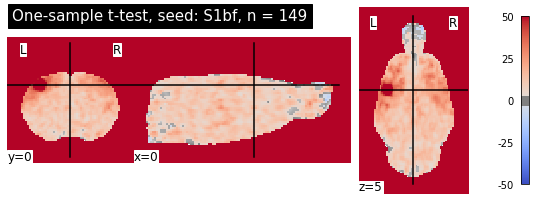

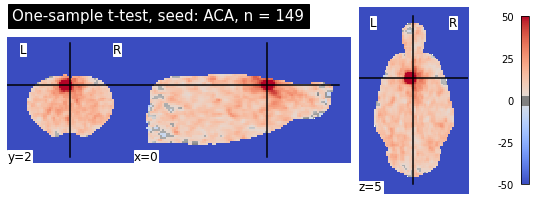

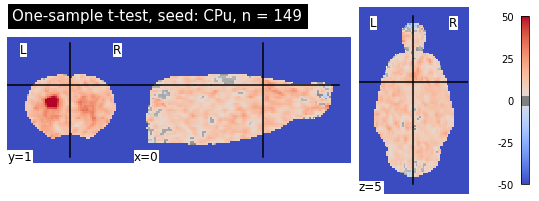

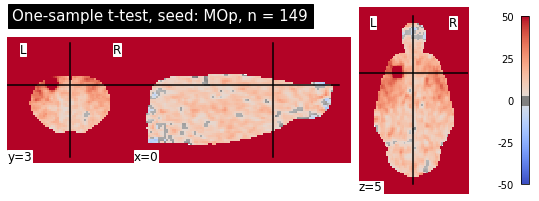

In [123]:
import re
from nilearn.glm.second_level import SecondLevelModel
from nilearn.plotting import plot_stat_map
from nilearn.image import concat_imgs
import matplotlib.pyplot as plt
import pandas as pd


bg_img = os.path.join(analysis_folder,
                      'template',
                      'SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1',
                      'SIGMA_Rat_Anatomical_Imaging',
                      'SIGMA_Rat_Anatomical_InVivo_Template',
                      'SIGMA_InVivo_Brain_Template_Masked.nii')

# output folders
output_incidence = os.path.join(
    analysis_folder, 'scratch', 'group_SBA_incidence')
os.makedirs(output_incidence, exist_ok=True)

# re-read the table
df_exclude = df.loc[(df['exclude'] != 'yes')].loc[(
    df['exp.type'] == 'resting-state')].loc[(df['rat.ses']) == 1]

# re-read all seed files in the path.
condtion = 'aromas'
seed_list = glob.glob(
    (os.path.join(analysis_folder, 'scratch', 'seed', condtion))+'/*')
seed_group = ['S1bf', 'ACA', 'CPu', 'MOp']
y_stack = [0.14, 2.2, 1.6, 3.1]

for count, seed in enumerate(seed_group):

    r = re.compile(seed)
    seed_list_sub = list(filter(r.findall, seed_list))
   # r = re.compile(str(i))
   # seed_list_sub = list(filter(r.findall, seed_list_sub))
    r = re.compile('ses-1')
    seed_list_sub = list(filter(r.findall, seed_list_sub))
    r = re.compile("(?=(" + "|".join(map(re.escape, map(str,
                                                        df_exclude['rat.sub']))) + "))")
    seed_list_sub = list(filter(r.findall, seed_list_sub))

    second_level_input = concat_imgs(seed_list_sub, auto_resample=True)
    design_matrix = pd.DataFrame([1] * len(seed_list_sub),
                                 columns=['intercept'])
    ma_img = math_img("np.mean(img, axis=-1) / (np.var(img,axis=-1)*np.sqrt(2/np.shape(img)[3]))",
                      img=second_level_input)
    
    #usual way of doing one sample t-test was buggy. Downside, cannot use z-score :-(
    #second_level_model = SecondLevelModel()
    # second_level_model = second_level_model.fit(second_level_input,
    #                                       design_matrix=design_matrix)

    #z_map = second_level_model.compute_contrast(output_type='z_score')

    filename_export = "Onesample_seed-"+seed
    filename_path = os.path.join(
        analysis_folder, 'scratch', output_incidence, filename_export)

    ma_img.to_filename(filename_path+'.nii.gz')

    filename_path = os.path.join(
        analysis_folder, 'scratch', output_incidence, filename_export)
    plot_stat_map(ma_img,
                  bg_img,
                  title='One-sample t-test, seed: ' + seed +
                  ', n = ' + str(len(seed_list_sub)),
                  threshold=3,
                  vmax=50,
                  symmetric_cbar=True,
                  cmap='coolwarm',
                  black_bg=False,
                  # display_mode="y",
                  cut_coords=(0, y_stack[count], 5),
                  output_file=filename_path+'.svg')

    # remake plot with output to jupyter notebook
    plot_stat_map(ma_img,
                  bg_img,
                  title='One-sample t-test, seed: ' + seed +
                  ', n = ' + str(len(seed_list_sub)),
                  threshold=3,
                  vmax=50,
                  symmetric_cbar=True,
                  cmap='coolwarm',
                  black_bg=False,
                  # display_mode="y",
                  cut_coords=(0, y_stack[count], 5))

UFuncTypeError: Cannot cast ufunc 'add' output from dtype('float64') to dtype('<i2') with casting rule 'same_kind'

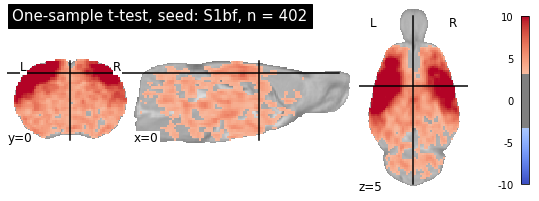

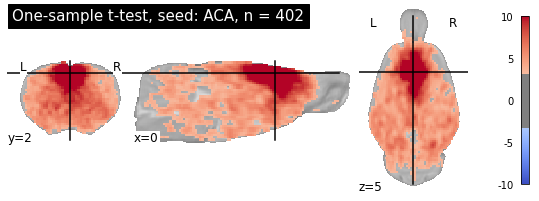

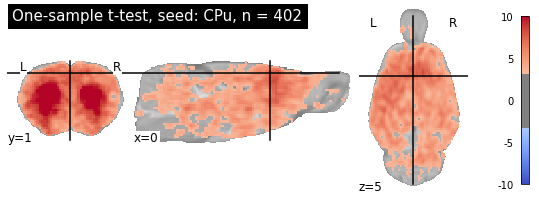

In [101]:
import re
from nilearn.glm.second_level import SecondLevelModel
from nilearn.plotting import plot_stat_map
from nilearn.image import concat_imgs, load_img, resample_to_img
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil



bg_img = os.path.join(analysis_folder,
                      'template',
                      'SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1',
                      'SIGMA_Rat_Anatomical_Imaging',
                      'SIGMA_Rat_Anatomical_InVivo_Template',
                      'SIGMA_InVivo_Brain_Template_Masked.nii')

# output folders
output_incidence = os.path.join(
    analysis_folder, 'scratch', 'group_SBA_incidence')
os.makedirs(output_incidence, exist_ok=True)

# re-read the table
df_exclude = df.loc[(df['exclude'] != 'yes')].loc[(
    df['exp.type'] == 'resting-state')].loc[(df['rat.ses']) == 1]

# re-read all seed files in the path.
condtion = 'aromas'
seed_list = glob.glob(
    (os.path.join(analysis_folder, 'scratch', 'seed', condtion))+'/*')
seed_group = ['S1bf', 'ACA', 'CPu', 'MOp']
y_stack = [0.14, 2.2, 1.6, 3.1]

for count, seed in enumerate(seed_group):

    dir = os.path.join(analysis_folder,"scratch","tmp")
    if os.path.exists(dir):
        shutil.rmtree(dir)
    os.mkdir(dir)

    r = re.compile(seed)
    seed_list_sub = list(filter(r.findall, seed_list))
    r = re.compile('ses-1')
    seed_list_sub = list(filter(r.findall, seed_list_sub))
    r = re.compile("(?=(" + "|".join(map(re.escape, map(str,
                                                        df_exclude['rat.sub']))) + "))")
    seed_list_sub = list(filter(r.findall, seed_list_sub))

    second_level_input =load_img(seed_list_sub[0])  

    for i in range(1, len(seed_list_sub)):
        resample_to_img(seed_list_sub[i], seed_list_sub[0]).to_filename(os.path.join(analysis_folder, 'scratch', 'tmp', os.path.basename(seed_list_sub[i])))

    

    second_level_list =  glob.glob(
        (os.path.join(analysis_folder, 'scratch', 'tmp'))+'/*')
    
    design_matrix = pd.DataFrame([1] * len(second_level_list),columns=['intercept'])

#second_level_model =  non_parametric_inference(second_level_list,
#                             design_matrix=design_matrix,
#                             model_intercept=True, n_perm=5000,
#                             two_sided_test=False, n_jobs=-1)


    second_level_model = SecondLevelModel()
    second_level_model = second_level_model.fit(second_level_list,
                                           design_matrix=design_matrix)

    z_map = second_level_model.compute_contrast(output_type='z_score')
    
    filename_export = "Onesample_seed-"+seed
    filename_path = os.path.join(
        analysis_folder, 'scratch', output_incidence, filename_export)
    
    plot_stat_map(z_map,
                  bg_img,
                  title='One-sample t-test, seed: ' + seed +
                  ', n = ' + str(len(seed_list_sub)),
                  threshold=3.2,
                  vmax=10,
                  symmetric_cbar=True,
                  cmap='coolwarm',
                  black_bg=False,
                  # display_mode="y",
                  cut_coords=(0, y_stack[count], 5),
                  output_file=filename_path+'.svg')

    plot_stat_map(z_map,
                  bg_img,
                  title='One-sample t-test, seed: ' + seed +
                  ', n = ' + str(len(seed_list_sub)),
                  symmetric_cbar=True,
                  cmap='coolwarm',
                  black_bg=False,
                  threshold=3.2,
                  vmax=10,
                  # display_mode="y",
                  cut_coords=(0, y_stack[count], 5))
    
    if os.path.exists(dir):
        shutil.rmtree(dir)


